In [1]:
%load_ext Cython

In [13]:
%matplotlib nbagg

In [10]:
import numpy

Iso contour implementation using Cython with a insertion algorithm to merge polygons together. The image is split into several blocks to find local iso contours. The result is finally merge all together. This way allow a full OpenMP optimization.

MarchingSquareCythonInsertOpenMp C++98
================================

In [2]:
import pyximport
_ = pyximport.install()

In [7]:
from impl.MarchingSquareCythonInsertOpenMp98 import MarchingSquareCythonInsertOpenMp98
ThisMarchingSquare = MarchingSquareCythonInsertOpenMp98

In [5]:
from impl.MarchingSquareCythonInsertOpenMp import MarchingSquareCythonInsertOpenMp

In [29]:
from impl.MarchingSquareSciKitImage import MarchingSquareSciKitImage

In [32]:
from impl.MarchingSquareCythonArrayOpt import MarchingSquareCythonArrayOpt

Test
====

In [11]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 1],
                     [0, 0, 1, 0, 0, 1],
                     [0, 0, 0, 0, 0, 1]], dtype=numpy.float32)

algo = ThisMarchingSquare(image, use_minmax_cache=True)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[5. , 0.5],
       [4.5, 1. ],
       [4.5, 2. ],
       [4.5, 3. ]], dtype=float32), array([[1.5, 1. ],
       [1. , 0.5],
       [0.5, 1. ],
       [1. , 1.5],
       [1.5, 1. ]], dtype=float32), array([[2.5, 2. ],
       [2. , 1.5],
       [1.5, 2. ],
       [2. , 2.5],
       [2.5, 2. ]], dtype=float32)]


In [12]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 1, 0, 0],
                     [0, 1, 1, 1, 1, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=numpy.float32)

algo = ThisMarchingSquare(image, use_minmax_cache=True)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[2. , 3.5],
       [1.5, 3. ],
       [1. , 2.5],
       [0.5, 2. ],
       [1. , 1.5],
       [1.5, 1. ],
       [2. , 0.5],
       [3. , 0.5],
       [3.5, 1. ],
       [4. , 1.5],
       [4.5, 2. ],
       [4. , 2.5],
       [3. , 2.5],
       [2.5, 3. ],
       [2. , 3.5]], dtype=float32)]


Utils
=====

In [36]:
try:
    import importlib
    importlib.reload(benchmark_utils)
except Exception as e:
    print(e)
import benchmark_utils

Test
=================

In [18]:
problem = benchmark_utils.create_test_problem()
print("Without mask + without minmax")
marching_square = MarchingSquareCythonInsertOpenMp(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("With mask + without minmax")
marching_square = MarchingSquareCythonInsertOpenMp(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("With mask + with minmax")
marching_square = MarchingSquareCythonInsertOpenMp(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]

no mask + no minmax
24.5 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.5 ms ± 5.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
mask + no minmax
19.5 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.5 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
mask + minmax
18 ms ± 868 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.3 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


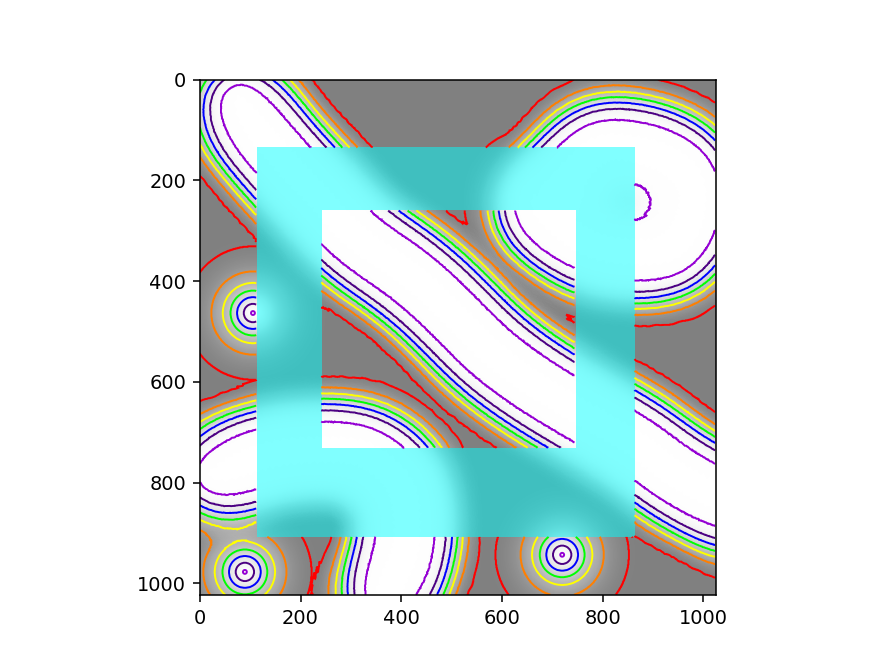

In [20]:
problem = benchmark_utils.create_test_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
benchmark_utils.plot_problem(problem, marching_square)

Test synthetic image
===========

<IPython.core.display.Javascript object>


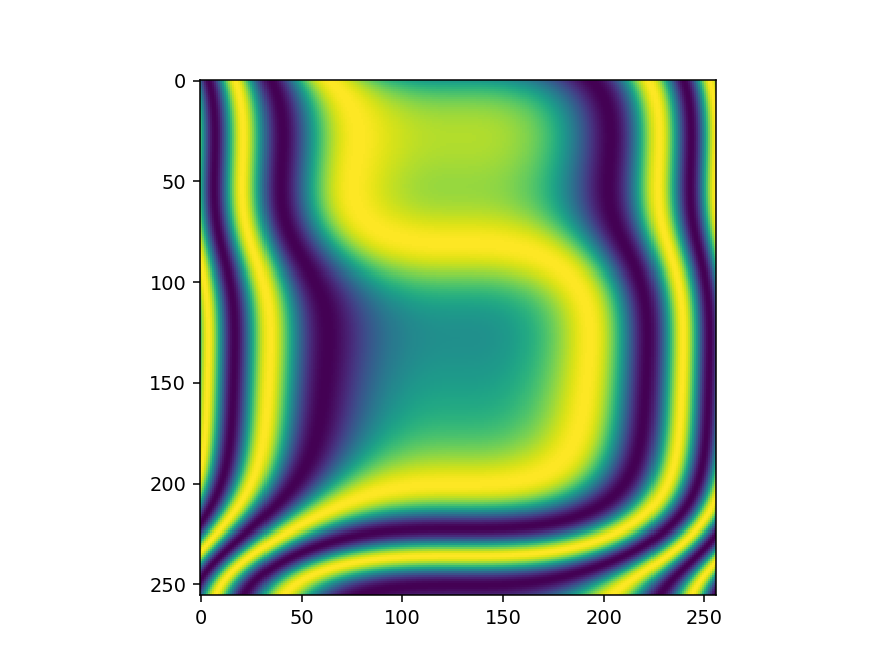

In [40]:
def create_data(size):
    half = size // 2
    y, x = numpy.ogrid[-half:half, -half:half]
    coef = 1 / half
    y, x = y * coef, x * coef
    data = x*x + y*y
    data = x*x*(x*2) + y*y/2**numpy.sin(y*5)
    data = numpy.sin(data * 6, dtype=numpy.float32)
    return data

problem = benchmark_utils.Problem(create_data(256))

benchmark_utils.show_problems([problem])

<IPython.core.display.Javascript object>


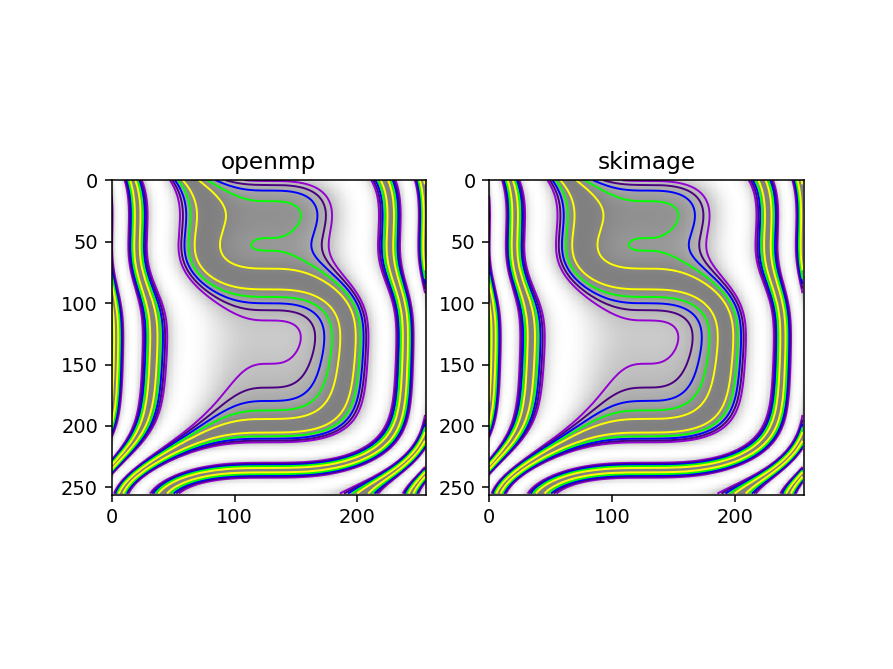

In [42]:
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(121)
pyplot.title("openmp")
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
benchmark_utils.imshow_problem(problem, marching_square)
pyplot.subplot(122)
pyplot.title("skimage")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
benchmark_utils.imshow_problem(problem, marching_square)
pyplot.show()

WOS detector (700K pixels)
==========================

In [22]:
problem = benchmark_utils.create_wos_problem()
print("With mask")
marching_square = MarchingSquareCythonInsertOpenMp(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareCythonInsertOpenMp(problem.image, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
16.8 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.8 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Without mask
30 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.8 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


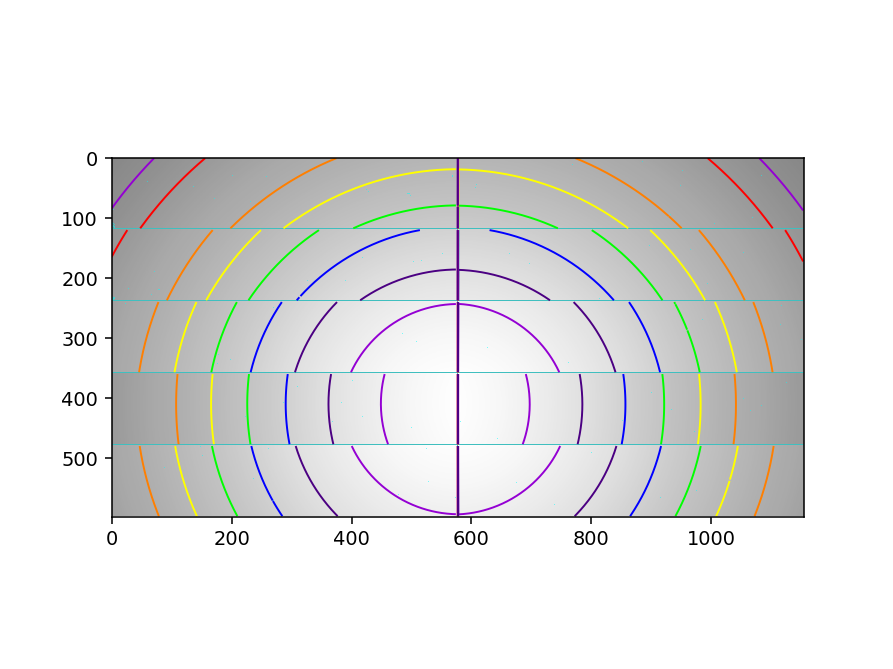

In [23]:
problem = benchmark_utils.create_wos_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
benchmark_utils.plot_problem(problem, marching_square)

Perkin Elmer (16M pixels)
=========================

In [24]:
problem = benchmark_utils.create_id22_17_problem()
print("Without mask + without minmax")
marching_square = MarchingSquareCythonInsertOpenMp(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("With mask + without minmax")
marching_square = MarchingSquareCythonInsertOpenMp(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("With mask + with minmax")
marching_square = MarchingSquareCythonInsertOpenMp(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
%timeit [marching_square.iso_contour(a) for a in problem.values]

Without mask + without minmax
248 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
280 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
With mask + without minmax
311 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
302 ms ± 45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
With mask + with minmax
29.8 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27.5 ms ± 5.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


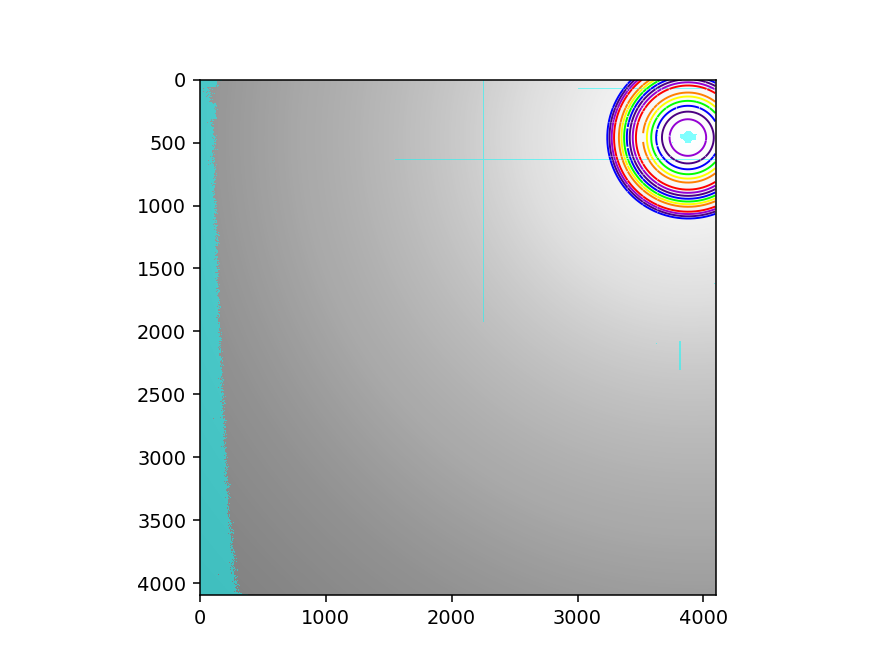

In [25]:
problem = benchmark_utils.create_id22_17_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
benchmark_utils.plot_problem(problem, marching_square)

<IPython.core.display.Javascript object>


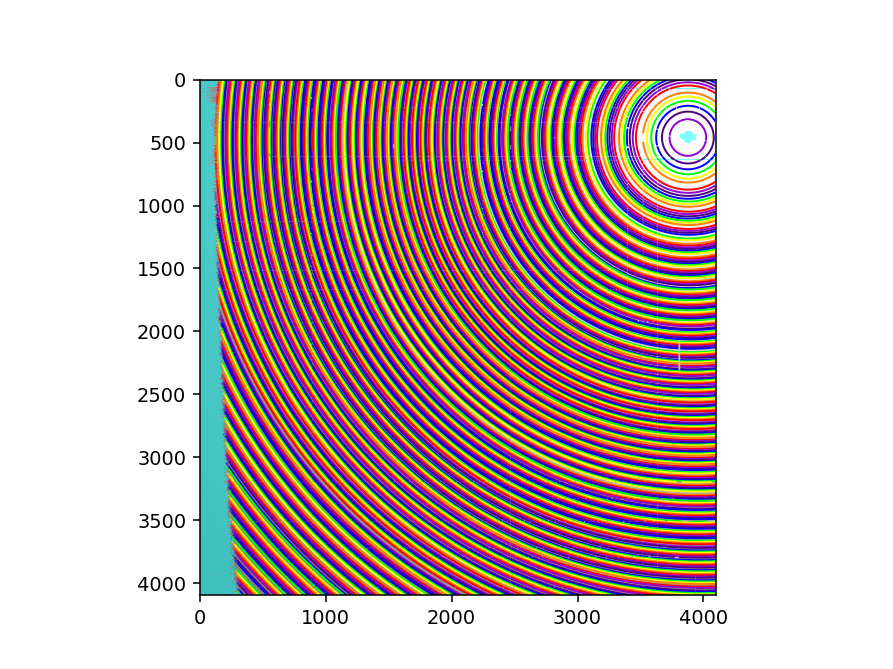

In [26]:
problem = benchmark_utils.create_id22_1441_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True)
benchmark_utils.plot_problem(problem, marching_square)

In [33]:
problem = benchmark_utils.create_id22_1441_problem()
print("skimage")
%timeit marching_square = MarchingSquareSciKitImage(problem.image, problem.mask); [marching_square.iso_contour(a) for a in problem.values]
print("Array")
%timeit marching_square = MarchingSquareCythonArrayOpt(problem.image, problem.mask); [marching_square.iso_contour(a) for a in problem.values]
print("Unordered map")
%timeit marching_square = MarchingSquareCythonInsertOpenMp(problem.image, problem.mask); [marching_square.iso_contour(a) for a in problem.values]
%timeit marching_square = MarchingSquareCythonInsertOpenMp(problem.image, problem.mask, use_minmax_cache=True); [marching_square.iso_contour(a) for a in problem.values]
print("Map")
%timeit marching_square = ThisMarchingSquare(problem.image, problem.mask); [marching_square.iso_contour(a) for a in problem.values]
%timeit marching_square = ThisMarchingSquare(problem.image, problem.mask, use_minmax_cache=True); [marching_square.iso_contour(a) for a in problem.values]

skimage
53.4 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Array
38.2 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Unordered map
7.14 s ± 562 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.2 s ± 243 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Map
6.84 s ± 415 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.86 s ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
